In [1]:
# detailed_response_analysis.ipynb
# Avery Krieger 07/27/2023

# this allows you to edit src code and run 
# (the alternative is to restart the kernel EVERY time you make a change to src...BAD)
%load_ext autoreload
%autoreload 2

from visanalysis.analysis import imaging_data, shared_analysis
from visanalysis.util import plot_tools

from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy import stats
from scipy.stats import wilcoxon
import pingouin as pg

import os
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from statannotations.Annotator import Annotator

/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Loading dataframe from pickle

Also establishing the paths for saving

### concat and save the advanced metrics


In [190]:
# exp_advanced_df_by_roi_v5 = pd.read_pickle(save_directory2 + 'exp_advanced_df_by_roi_v5.pkl') 
# control_advanced_df_by_roi_v5 = pd.read_pickle(save_directory2 + 'control_advanced_df_by_roi_v5.pkl')
# rnai_advanced_df_by_roi_v3 = pd.read_pickle(save_directory2 + 'rnai_advanced_df_by_roi_v3.pkl')

# # concatenate them
# all_advanced_df_by_roi_v5 = pd.concat([exp_advanced_df_by_roi_v5, control_advanced_df_by_roi_v5, rnai_advanced_df_by_roi_v3])
# # save it as a pkl
# all_advanced_df_by_roi_v5.to_pickle(save_directory2 + 'exp_control_rnai_advanced_by_roi_v6.pkl')


In [2]:
save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/detailed_response/" #+ experiment_file_name + "/"
save_directory2 = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/flash_w_opto_step/" #+ experiment_file_name + "/"

Path(save_directory).mkdir(exist_ok=True)

exp_control_rnai_advanced_by_roi = pd.read_pickle(save_directory2 + 'exp_control_rnai_advanced_by_roi_v13.pkl') # exp_control_rnai_advanced_by_roi_v2 exp_control_rnai_advanced_by_roi

In [4]:
exp_control_rnai_advanced_by_roi

,ROI,Layer,PtT_Ratio,Pos_Integral,Neg_Integral,Integral_Ratio,Peak_Index,Trough_Index,Opto,Window,Type
0,0,[Proximal],-1.861812,0.106203,0.059322,1.790275,5.0,11.0,0,0,Experimental
1,0,[Proximal],-3.672173,0.172345,0.030852,5.586120,5.0,11.0,0,1,Experimental
2,0,[Proximal],-4.508087,0.169887,0.030115,5.641305,4.0,10.0,0,2,Experimental
3,0,[Proximal],-8.062990,0.185969,0.012524,14.848439,4.0,10.0,0,3,Experimental
4,0,[Proximal],-3.453907,0.118491,0.042438,2.792099,5.0,12.0,1,0,Experimental
...,...,...,...,...,...,...,...,...,...,...,...
187,15,[Proximal],-15.269358,0.875430,0.042788,20.459476,4.0,13.0,1,3,RNAi
188,15,[Proximal],-30.932963,0.970465,0.029206,33.228634,4.0,17.0,2,0,RNAi
189,15,[Proximal],-17.620723,0.980728,0.035660,27.502330,5.0,16.0,2,1,RNAi
190,15,[Proximal],-24.301167,0.999009,0.028268,35.340812,5.0,15.0,2,2,RNAi


## Subselect from the big DF

We want:
- Proximal layer
- Window 0

In [3]:
# get the correct dataframe set up
which_df_placeholder = exp_control_rnai_advanced_by_roi
# copy, don't just set equal. Then combine the opto intensities 1 and 2
prox_win0_df = which_df_placeholder.loc[(which_df_placeholder['Layer'] == 'Proximal') & (which_df_placeholder['Window'] == 0)]

exp_control_rnai_advanced_by_roi # exp_control_rnai_advanced_by_roi prox_win0_df
prox_win0_df

,ROI,Layer,PtT_Ratio,Pos_Integral,Neg_Integral,Integral_Ratio,Peak_Index,Trough_Index,Opto,Window,Type


# Violin Plots

First, violin plots for Experimental, Control, and RNAi conditions. Then, just Control and RNAi (for visualizations). 

The metrics to plot are: "PtT_Ratio", "Pos_Integral", "Neg_Integral", "Integral_Ratio", "Peak_Index", "Trough_Index"
- Peak-to-Trough Ratio
- Positive Integral value
- Negative Integral (absolute value)
- Integral Ratio
- Peak Index (index where peak occurs; proxy for tau)
- Trough Index

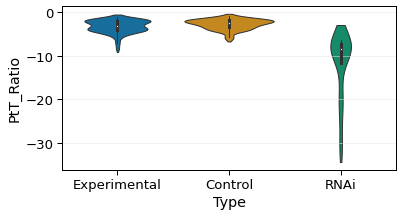

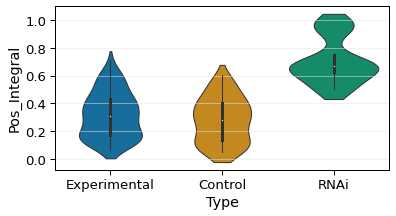

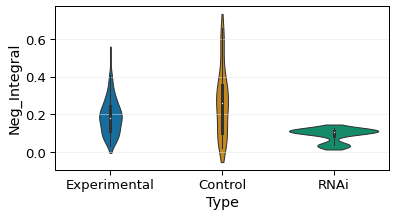

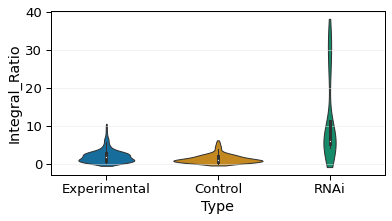

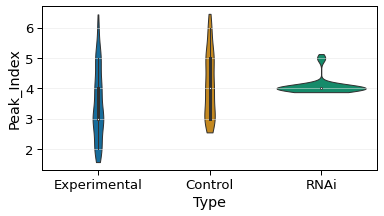

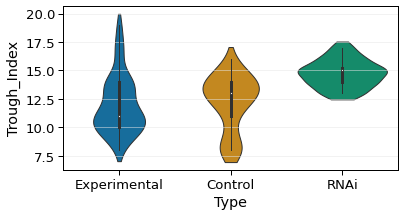

In [54]:
# Rapidly plot some metrics - 
save_fig = False
dv_set = ["PtT_Ratio", "Pos_Integral", "Neg_Integral", "Integral_Ratio", "Peak_Index", "Trough_Index"] 
win_set = [0, 1, 2]
type_set = ['Experimental', 'Control', 'RNAi']

for dv in dv_set:
    sns.set_context("paper", font_scale=1.5)
    comp_fig, comp_ax = plt.subplots(1, figsize=(6, 3))
    # Now, make the violinplot of the ROIs
    sns.violinplot(
        ax=comp_ax, data=prox_win0_df, x='Type', y=dv, 
        palette='colorblind', orient='v', linewidth=1,
        cut=1,
    )
    comp_ax.grid(axis="y", color="0.9", linestyle="-", linewidth=1, alpha=0.5)
    if save_fig == True:
        comp_fig.savefig(save_directory + dv + '_by_type.png', dpi=300, bbox_inches='tight')
        comp_fig.savefig(save_directory + dv + '_by_type.svg', dpi=300, bbox_inches='tight')


Getting just the control and rnai conditions into a df

In [46]:
prox_win0_con = prox_win0_df.loc[(prox_win0_df['Type'] == 'Control')]
prox_win0_rnai = prox_win0_df.loc[(prox_win0_df['Type'] == 'RNAi')]
# concatenate the two df
prox_win0_con_rnai = pd.concat([prox_win0_con, prox_win0_rnai])
prox_win0_con_rnai

,ROI,Layer,PtT_Ratio,Pos_Integral,Neg_Integral,Integral_Ratio,Peak_Index,Trough_Index,Opto,Window,Type
0,0,Proximal,-6.187824,0.563490,0.097406,5.784989,5.0,15.0,0,0,Control
4,0,Proximal,-5.653972,0.508611,0.102896,4.942980,6.0,16.0,1,0,Control
8,0,Proximal,-4.066961,0.446758,0.139193,3.209637,5.0,15.0,2,0,Control
12,1,Proximal,-2.580714,0.365407,0.355398,1.028161,6.0,14.0,0,0,Control
16,1,Proximal,-4.124945,0.475423,0.260499,1.825049,6.0,13.0,1,0,Control
...,...,...,...,...,...,...,...,...,...,...,...
172,14,Proximal,-8.194950,0.680440,0.096838,7.026585,4.0,14.0,1,0,RNAi
176,14,Proximal,-7.369979,0.662247,0.107773,6.144835,5.0,14.0,2,0,RNAi
180,15,Proximal,-18.328044,0.969836,0.030707,31.583129,4.0,13.0,0,0,RNAi
184,15,Proximal,-22.732227,0.961634,0.038950,24.689041,4.0,14.0,1,0,RNAi


Just the control and RNAi conditions, now

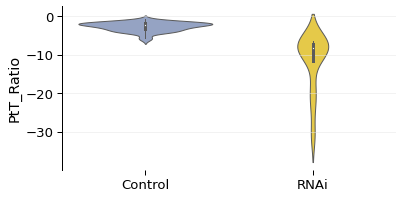

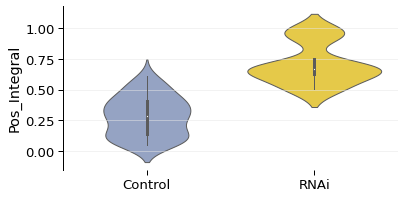

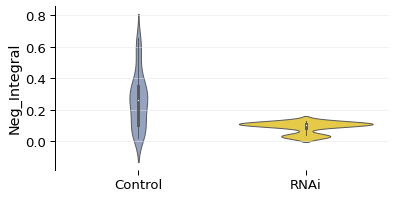

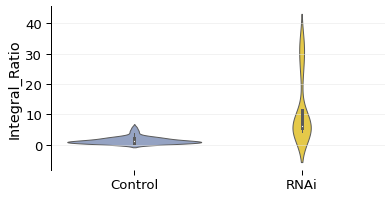

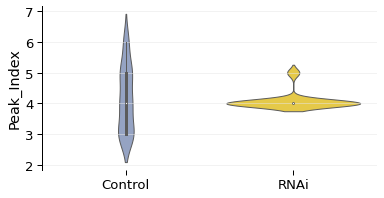

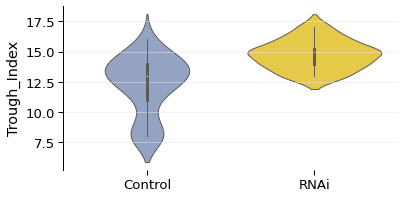

In [18]:
save_fig = False

cmap = plt.get_cmap('Set2') # also 'cool' 'winter' 'PRGn' 'Pastel1' 'YlGnBu' 'twilight'
colors = [cmap(i) for i in np.linspace(0, 1.0, 8)]
selected_colors = [colors[2], colors[5]]

dv_set = ["PtT_Ratio", "Pos_Integral", "Neg_Integral", "Integral_Ratio", "Peak_Index", "Trough_Index"] 

for dv in dv_set:
    sns.set_context("paper", font_scale=1.5)
    comp_fig, comp_ax = plt.subplots(1, figsize=(6, 3))
    # Now, make the violinplot of the ROIs
    sns.violinplot(
        ax=comp_ax, data=prox_win0_con_rnai, x='Type', y=dv, 
        palette=selected_colors, orient='v', linewidth=1,
        cut=2,
    )
    comp_ax.grid(axis="y", color="0.9", linestyle="-", linewidth=1, alpha=0.5)
    sns.despine(bottom=True)
    comp_ax.set_xlabel('')

    if save_fig:
        comp_fig.savefig(save_directory + '5D-ALTv2' + dv + '_violinplot_con_rnai.png', dpi=300, bbox_inches='tight')
        comp_fig.savefig(save_directory + '5D-ALTv2' + dv + '_violinplot_con_rnai.svg', dpi=300, bbox_inches='tight')

## Running some stats!

Comparing control and RNAi metrics

First we'll see if they are parametric and homogeneous

In [196]:
# calculating homogeneity of variance and distribtion normality to assess if parametric tests can be used
df_for_stats = prox_win0_con_rnai
control_subset = df_for_stats.loc[(df_for_stats['Type'] == 'control')]
rnai_subset = df_for_stats.loc[(df_for_stats['Type'] == 'RNAi')]

dv_set = ["PtT_Ratio", "Pos_Integral", "Neg_Integral", "Integral_Ratio", "Peak_Index", "Trough_Index"] 

for dv in dv_set:
    print(f'dv: {dv}')
    print('Homogeneity of variance')
    print(stats.levene(control_subset[dv], rnai_subset[dv]))
    print('\nNormality')
    print(stats.shapiro(control_subset[dv]))
    print(stats.shapiro(rnai_subset[dv]))
    print(stats.ttest_ind(control_subset[dv], rnai_subset[dv]))
    print('\n\n')


dv: PtT_Ratio
Homogeneity of variance
LeveneResult(statistic=5.534767164881713, pvalue=0.020436445835545623)

Normality
ShapiroResult(statistic=0.9310683608055115, pvalue=0.002205005381256342)
ShapiroResult(statistic=0.3103790283203125, pvalue=4.269084001237711e-14)
Ttest_indResult(statistic=3.2011137047250995, pvalue=0.001794023887910157)



dv: Pos_Integral
Homogeneity of variance
LeveneResult(statistic=0.2724489909897479, pvalue=0.6027527894393142)

Normality
ShapiroResult(statistic=0.9507644772529602, pvalue=0.016922002658247948)
ShapiroResult(statistic=0.8476424813270569, pvalue=1.1280806575086899e-05)
Ttest_indResult(statistic=-4.295499776442811, pvalue=3.7992270754632844e-05)



dv: Neg_Integral
Homogeneity of variance
LeveneResult(statistic=33.434693408144845, pvalue=7.12324505693645e-08)

Normality
ShapiroResult(statistic=0.9159234762191772, pvalue=0.000527669326402247)
ShapiroResult(statistic=0.9685148000717163, pvalue=0.1917591691017151)
Ttest_indResult(statistic=7.076599695

Pos/Neg integral not homogenous in their variance. Non parametric

In [201]:
is_par = False
adj_type = 'bonf'
alt_hypo = 'greater' # 'less' 'greater' 'two-sided'Annotator

# calculate the stats
for dv in dv_set:
    paired_t_results = pg.pairwise_tests(data=prox_win0_con_rnai, dv=dv, between='Type', parametric=is_par, padjust=adj_type, effsize='cohen', alternative=alt_hypo)
    print(f'dv: {dv}')
    print(paired_t_results.loc[0, "p-unc"])
    print(paired_t_results)
    print('\n\n')
    

dv: PtT_Ratio
1.0
  Contrast     A        B  Paired  Parametric  U-val alternative  p-unc  \
0     Type  RNAi  control   False       False   22.0     greater    1.0   

     cohen  
0 -0.60968  



dv: Pos_Integral
0.0002274659511915275
  Contrast     A        B  Paired  Parametric   U-val alternative     p-unc  \
0     Type  RNAi  control   False       False  2123.0     greater  0.000227   

      cohen  
0  0.818115  



dv: Neg_Integral
0.9999999998501433
  Contrast     A        B  Paired  Parametric  U-val alternative  p-unc  \
0     Type  RNAi  control   False       False  466.0     greater    1.0   

    cohen  
0 -1.3478  



dv: Integral_Ratio
2.9090725457581877e-15
  Contrast     A        B  Paired  Parametric   U-val alternative  \
0     Type  RNAi  control   False       False  2850.0     greater   

          p-unc     cohen  
0  2.909073e-15  1.081057  



dv: Peak_Index
0.8547586150385249
  Contrast     A        B  Paired  Parametric   U-val alternative     p-unc  \
0     

# Histograms and Violins

In [47]:
prox_win0_df.index.is_unique
prox_win0_df.index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,

In [50]:
prox_win0_df.reset_index(inplace=True)
prox_win0_con_rnai.reset_index(inplace=True)

/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

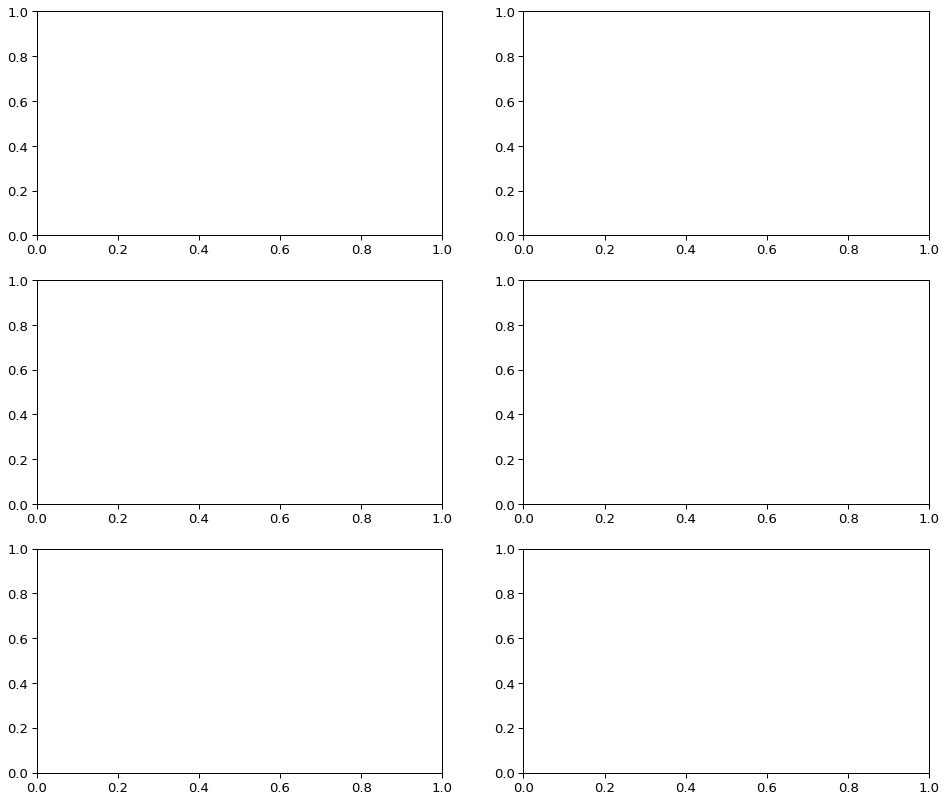

In [55]:
save_fig = False
dv_set = ["PtT_Ratio", "Integral_Ratio", "Peak_Index", "Pos_Integral", "Trough_Index", "Neg_Integral"]

df_set = [prox_win0_df, prox_win0_con_rnai]

for df in df_set:

    sns.set_context("paper", font_scale=1.5)
    hist_figs, hist_axes = plt.subplots(3, 2, figsize=(16, 14))
    hist_axes = hist_axes.flatten()
    for dv, hist_ax in zip(dv_set, hist_axes):
        sns.histplot(data=df, x=dv, hue='Type', ax=hist_ax, kde=True, stat='probability', common_norm=False, multiple='dodge',element="bars", palette='colorblind')
        hist_ax.set_ylabel('')
        sns.despine(fig=hist_figs, top=True, right=True, bottom=True)
    # remove legends from all but the first plot
    for hist_ax in hist_axes[1:]:
        hist_ax.get_legend().remove()
        
    # same but with violinplots
    sns.set_context("paper", font_scale=1.5)
    viol_figs, viol_axes = plt.subplots(3, 2, figsize=(18, 14))
    viol_axes = viol_axes.flatten()
    for dv, viol_ax in zip(dv_set, viol_axes):
        sns.violinplot(ax=viol_ax, data=df, x='Type', y=dv, 
            palette='colorblind', orient='v', linewidth=1.5,
            cut=2,
        )

    for viol_ax in viol_axes:
        
        viol_ax.grid(axis="y", color="0.9", linestyle="-", linewidth=1)

        sns.despine(fig=viol_figs, top=True, right=True, bottom=True,)
        # remove x-axis label
        viol_ax.set_xlabel('')
    # set y limits of subplot 1
    viol_axes[1].set_ylim([-200, 200])

    if save_fig == True:
        hist_figs.savefig(save_directory + 'histogram_grid_by_type.png', dpi=300, bbox_inches='tight')
        viol_figs.savefig(save_directory + 'violinplots_grid_by_type.png', dpi=300, bbox_inches='tight')

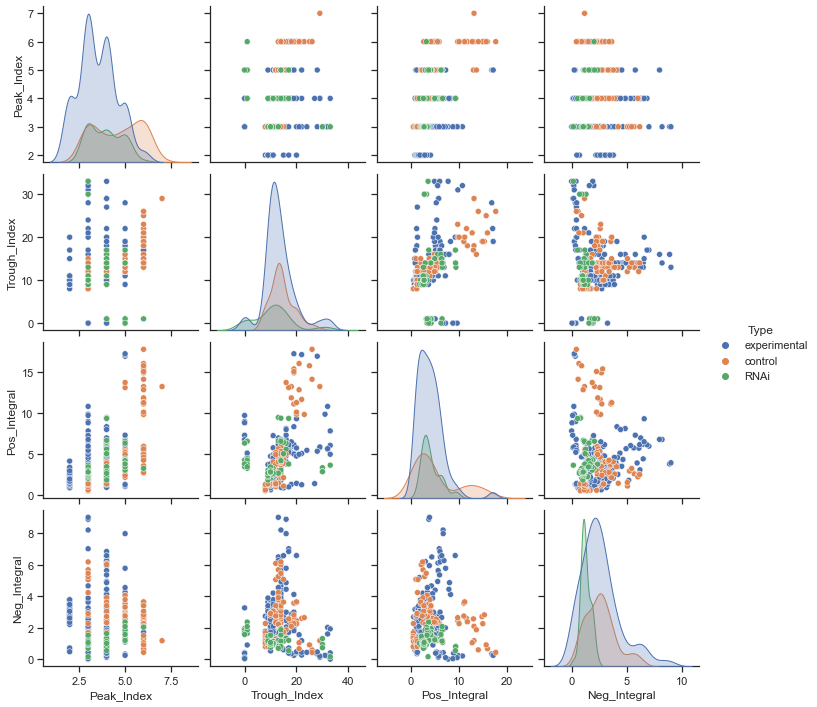

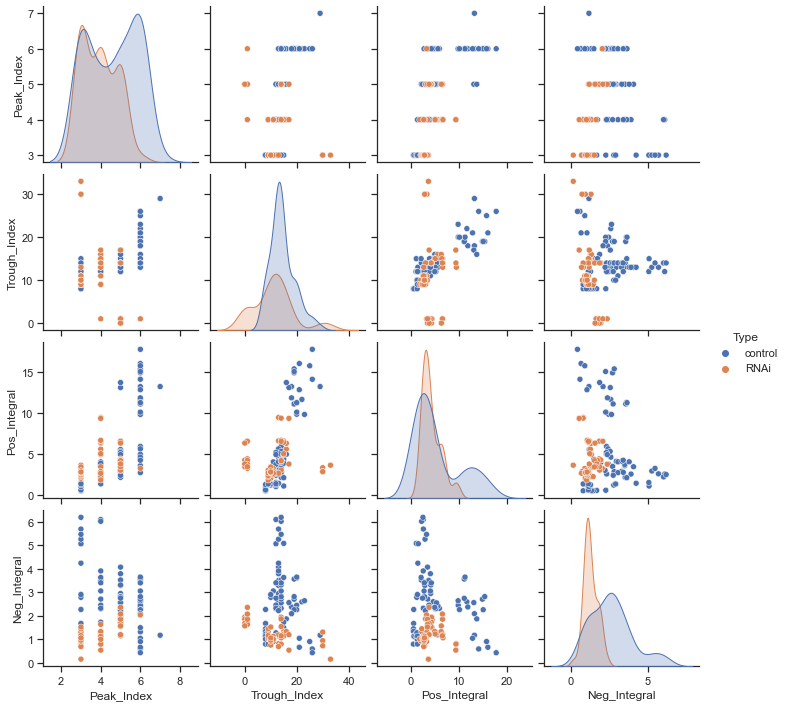

In [157]:
sns.set_theme(style="ticks")

sns.pairplot(
    prox_win0_df, hue="Type", 
    x_vars=["Peak_Index", "Trough_Index", "Pos_Integral", "Neg_Integral"],
    y_vars=["Peak_Index", "Trough_Index", "Pos_Integral", "Neg_Integral"],
    )

sns.pairplot(
    prox_win0_con_rnai, hue="Type", 
    x_vars=["Peak_Index", "Trough_Index", "Pos_Integral", "Neg_Integral"],
    y_vars=["Peak_Index", "Trough_Index", "Pos_Integral", "Neg_Integral"],
    )

Text(0, 0.5, 'Negative Integral')

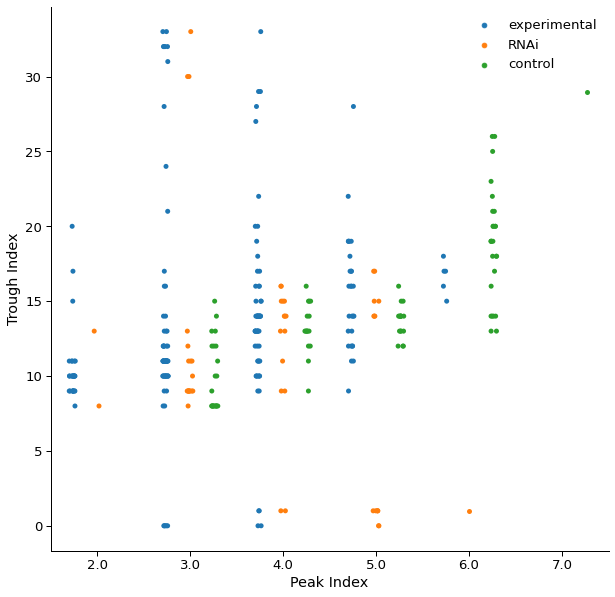

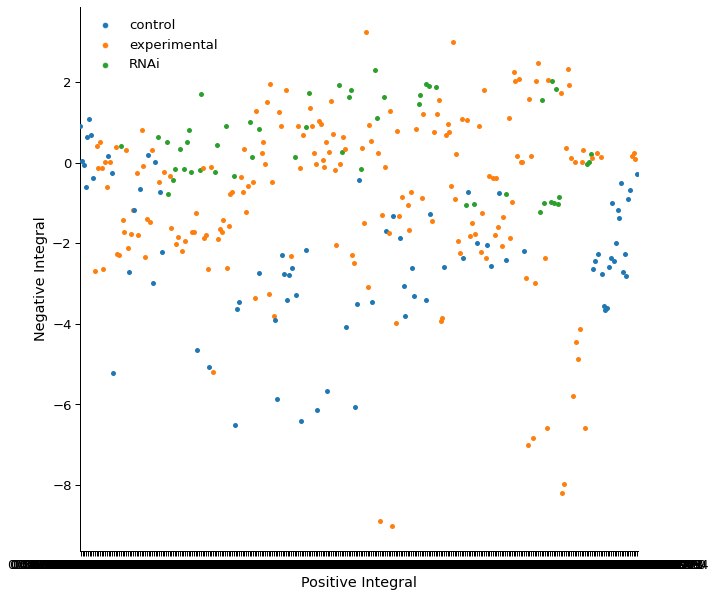

In [100]:
sns.set_context("paper", font_scale=1.5)


pt_fig, pt_ax = plt.subplots(1, figsize=(10, 10))
sns.stripplot(
    data=prox_win0_df, x="Peak_Index", y="Trough_Index", hue="Type", dodge=True
)
pt_ax.legend(title='', frameon=False)
sns.despine(fig=pt_fig, top=True, right=True,)
pt_ax.set_xlabel("Peak Index")
pt_ax.set_ylabel("Trough Index")

# same but with integrals
sns.set_context("paper", font_scale=1.5)
pt_fig, pt_ax = plt.subplots(1, figsize=(10, 10))
sns.stripplot(
    data=prox_win0_df, x="Pos_Integral", y="Neg_Integral", hue="Type", dodge=True
)
pt_ax.legend(title='', frameon=False)
sns.despine(fig=pt_fig, top=True, right=True,)
pt_ax.set_xlabel("Positive Integral")
pt_ax.set_ylabel("Negative Integral")